In [31]:
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import pandas as pd
import inspect
from PIL import Image

## Explore the Udacity driving dataset

In [49]:
print(inspect.signature(pd.read_csv))
print(patches.Rectangle)
print(np.argmax)

(filepath_or_buffer, sep=',', delimiter=None, header='infer', names=None, index_col=None, usecols=None, squeeze=False, prefix=None, mangle_dupe_cols=True, dtype=None, engine=None, converters=None, true_values=None, false_values=None, skipinitialspace=False, skiprows=None, nrows=None, na_values=None, keep_default_na=True, na_filter=True, verbose=False, skip_blank_lines=True, parse_dates=False, infer_datetime_format=False, keep_date_col=False, date_parser=None, dayfirst=False, iterator=False, chunksize=None, compression='infer', thousands=None, decimal=b'.', lineterminator=None, quotechar='"', quoting=0, escapechar=None, comment=None, encoding=None, dialect=None, tupleize_cols=False, error_bad_lines=True, warn_bad_lines=True, skipfooter=0, skip_footer=0, doublequote=True, delim_whitespace=False, as_recarray=False, compact_ints=False, use_unsigned=False, low_memory=True, buffer_lines=None, memory_map=False, float_precision=None)
<class 'matplotlib.patches.Rectangle'>
<function argmax at 0

In [33]:
annotation = pd.read_csv("./driving_data/object-dataset/labels.csv", sep = ' ', 
                         names = ['frame', 'xmin', 'ymin', 'xmax', 'ymax', 'occluded', 'label', 'attributes'])

In [34]:
annotation.head(5)

,frame,xmin,ymin,xmax,ymax,occluded,label,attributes
0,1478019952686311006.jpg,950,574,1004,620,0,car,NaN
1,1478019952686311006.jpg,1748,482,1818,744,0,pedestrian,NaN
2,1478019953180167674.jpg,872,586,926,632,0,car,NaN
3,1478019953689774621.jpg,686,566,728,618,1,truck,NaN
4,1478019953689774621.jpg,716,578,764,622,0,car,NaN


In [320]:
index = 23
im = np.array(Image.open("./driving_data/object-dataset/" + annotation["frame"][index]), np.uint8)

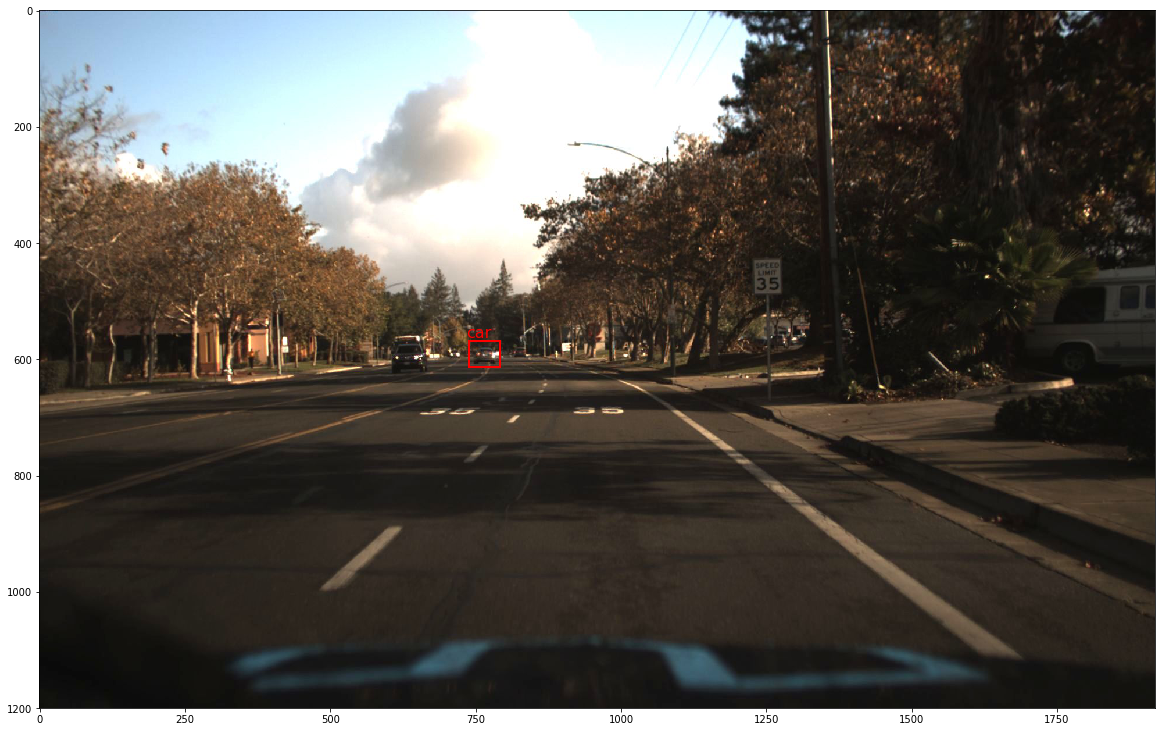

In [321]:
figure = plt.figure(figsize=(20, 20))
ax = figure.add_subplot(1, 1, 1)
ax.imshow(im)

# Add the bouding boxes to the image
(left, right, top, bottom) = (annotation["xmin"][index], annotation["xmax"][index], annotation["ymin"][index], annotation["ymax"][index])
rect = patches.Rectangle((left, top), right - left, bottom - top, linewidth = 2, edgecolor = 'r', facecolor = 'none')
ax.add_patch(rect)
ax.text(left - 5, top - 5, annotation["label"][index], fontsize = 16, color = 'red')

plt.show()

In [47]:
im.shape

(1200, 1920, 3)

In [48]:
pd.unique(annotation["label"])

array(['car', 'pedestrian', 'truck', 'trafficLight', 'biker'], dtype=object)

In [198]:
labels = ["car", 'truck', 'pedestrian', 'trafficLight', 'biker']

## 1 - Problem Statement

You are working on a self-driving car. As a critical component of this project, you'd like to first build a car detection system. To collect data, you've mounted a camera to the hood (meaning the front) of the car, which takes pictures of the road ahead every few seconds while you drive around. 

If you have 80 classes that you want YOLO to recognize, you can represent the class label $c$ either as an integer from 1 to 80, or as an 80-dimensional vector (with 80 numbers) one component of which is 1 and the rest of which are 0. The video lectures had used the latter representation; in this notebook, we will use both representations, depending on which is more convenient for a particular step.  

In this exercise, you will learn how YOLO works, then apply it to car detection. Because the YOLO model is very computationally expensive to train, we will load pre-trained weights for you to use. 

## 2 - YOLO

YOLO ("you only look once") is a popular algoritm because it achieves high accuracy while also being able to run in real-time. This algorithm "only looks once" at the image in the sense that it requires only one forward propagation pass through the network to make predictions. After non-max suppression, it then outputs recognized objects together with the bounding boxes.

### 2.1 - Model details

First things to know:
- The **input** is a batch of images of shape (m, 608, 608, 3)
- The **output** is a list of bounding boxes along with the recognized classes. Each bounding box is represented by 6 numbers $(p_c, b_x, b_y, b_h, b_w, c)$ as explained above. If you expand $c$ into an 80-dimensional vector, each bounding box is then represented by 85 numbers. 

We will use 5 anchor boxes. So you can think of the YOLO architecture as the following: IMAGE (m, 608, 608, 3) -> DEEP CNN -> ENCODING (m, 19, 19, 5, 85).

Lets look in greater detail at what this encoding represents. 

<img src="img/architecture.png" style="width:700px;height:400;">
<caption><center> <u> **Figure 2** </u>: **Encoding architecture for YOLO**<br> </center></caption>

If the center/midpoint of an object falls into a grid cell, that grid cell is responsible for detecting that object. **Reduction factor** comes from $\frac{608}{19} = 32$.

Since we are using 5 anchor boxes, each of the 19 x19 cells thus encodes information about 5 boxes. **Anchor boxes are defined only by their width and height**.

For simplicity, we will flatten the last two last dimensions of the shape (19, 19, 5, 85) encoding. So the output of the Deep CNN is (19, 19, 425).

<img src="img/flatten.png" style="width:700px;height:400;">
<caption><center> <u> **Figure 3** </u>: **Flattening the last two last dimensions**<br> </center></caption>

Now, for each box (of each cell) we will compute the following elementwise product and extract a probability that the box contains a certain class.

<img src="img/probability_extraction.png" style="width:700px;height:400;">
<caption><center> <u> **Figure 4** </u>: **Find the class detected by each box**<br> </center></caption>


Here's one way to visualize what YOLO is predicting on an image:
- For each of the 19x19 grid cells, find the maximum of the probability scores (taking a max across both the 5 anchor boxes and across different classes). 
- Color that grid cell according to what object that grid cell considers the most likely.

Doing this results in this picture: 

<img src="img/proba_map.png" style="width:300px;height:300;">
<caption><center> <u> **Figure 5** </u>: Each of the 19x19 grid cells colored according to which class has the largest predicted probability in that cell.<br> </center></caption>

Note that this visualization isn't a core part of the YOLO algorithm itself for making predictions; it's just a nice way of visualizing an intermediate result of the algorithm. 


Another way to visualize YOLO's output is to plot the bounding boxes that it outputs. Doing that results in a visualization like this:  

<img src="img/anchor_map.png" style="width:200px;height:200;">
<caption><center> <u> **Figure 6** </u>: Each cell gives you 5 boxes. In total, the model predicts: 19x19x5 = 1805 boxes just by looking once at the image (one forward pass through the network)! Different colors denote different classes. <br> </center></caption>

In the figure above, we plotted only boxes that the model had assigned a high probability to, but this is still too many boxes. You'd like to filter the algorithm's output down to a much smaller number of detected objects. To do so, you'll use non-max suppression. Specifically, you'll carry out these steps: 
- Get rid of boxes with a low score (meaning, the box is not very confident about detecting a class)
- Select only one box when several boxes overlap with each other and detect the same object.



### 2.2 - Filtering with a threshold on class scores

You are going to apply a first filter by thresholding. You would like to get rid of any box for which the class "score" is less than a chosen threshold. 

The model gives you a total of 19x19x5x85 numbers, with each box described by 85 numbers. It'll be convenient to rearrange the (19,19,5,85) (or (19,19,425)) dimensional tensor into the following variables:  
- `box_confidence`: tensor of shape $(19 \times 19, 5, 1)$ containing $p_c$ (confidence probability that there's some object) for each of the 5 boxes predicted in each of the 19x19 cells.
- `boxes`: tensor of shape $(19 \times 19, 5, 4)$ containing $(b_x, b_y, b_h, b_w)$ for each of the 5 boxes per cell.
- `box_class_probs`: tensor of shape $(19 \times 19, 5, 80)$ containing the detection probabilities $(c_1, c_2, ... c_{80})$ for each of the 80 classes for each of the 5 boxes per cell.

**Exercise**: Implement `yolo_filter_boxes()`.
1. Compute box scores by doing the elementwise product as described in Figure 4. The following code may help you choose the right operator: 
```python
a = np.random.randn(19*19, 5, 1)
b = np.random.randn(19*19, 5, 80)
c = a * b # shape of c will be (19*19, 5, 80)
```
2. For each box, find:
    - the index of the class with the maximum box score (Be careful with what axis you choose; consider using axis=-1)
    - the corresponding box score (Be careful with what axis you choose; consider using axis=-1)
3. Create a mask by using a threshold. As a reminder: `([0.9, 0.3, 0.4, 0.5, 0.1] < 0.4)` returns: `[False, True, False, False, True]`. The mask should be True for the boxes you want to keep. 
4. Use TensorFlow to apply the mask to box_class_scores, boxes and box_classes to filter out the boxes we don't want. You should be left with just the subset of boxes you want to keep. 


In [98]:
def yolo_filter_boxes(box_confidence, boxes, box_class_probs, threshold = .6):
    """Filters YOLO boxes by thresholding on object and class confidence.
    
    Arguments:
    box_confidence -- tensor of shape (19, 19, 5, 1)
    boxes -- tensor of shape (19, 19, 5, 4)
    box_class_probs -- tensor of shape (19, 19, 5, 80)
    threshold -- real value, if [ highest class probability score < threshold], then get rid of the corresponding box
    
    Returns:
    scores -- tensor of shape (None,), containing the class probability score for selected boxes
    boxes -- tensor of shape (None, 4), containing (b_x, b_y, b_h, b_w) coordinates of selected boxes
    classes -- tensor of shape (None,), containing the index of the class detected by the selected boxes
    
    Note: "None" is here because you don't know the exact number of selected boxes, as it depends on the threshold. 
    For example, the actual output size of scores would be (10,) if there are 10 boxes.
    """
    
    # Step 1: Compute box scores
    box_scores = box_confidence * box_class_probs
    
    # Step 2: Find the box_classes thanks to the max box_scores, keep track of the corresponding score
    box_classes = tf.argmax(box_scores, axis = -1)
    box_class_scores = tf.reduce_max(box_scores, axis = -1)
    
    # Step 3: Create a filtering mask based on "box_class_scores" by using "threshold". The mask should have the
    # same dimension as box_class_scores, and be True for the boxes you want to keep (with probability >= threshold)
    filtering_mask = tf.greater_equal(box_class_scores, threshold)

    
    # Step 4: Apply the mask to scores, boxes and classes
    scores = tf.boolean_mask(box_class_scores, filtering_mask)  # Numpy equivalent: box_class_scores[filtering_mask]
    boxes = tf.boolean_mask(boxes, filtering_mask)
    classes = tf.boolean_mask(box_classes, filtering_mask)
    
    return scores, boxes, classes

In [99]:
with tf.Session() as test_a:
    box_confidence = tf.random_normal([19, 19, 5, 1], mean=1, stddev=4, seed = 1)
    boxes = tf.random_normal([19, 19, 5, 4], mean=1, stddev=4, seed = 1)
    box_class_probs = tf.random_normal([19, 19, 5, 80], mean=1, stddev=4, seed = 1)
    scores, boxes, classes = yolo_filter_boxes(box_confidence, boxes, box_class_probs, threshold = 0.5)
    print("scores[2] = " + str(scores[2].eval()))
    print("boxes[2] = " + str(boxes[2].eval()))
    print("classes[2] = " + str(classes[2].eval()))
    print("scores.shape = " + str(scores.shape))
    print("boxes.shape = " + str(boxes.shape))
    print("classes.shape = " + str(classes.shape))

scores[2] = 10.7506
boxes[2] = [ 8.42653275  3.27136683 -0.5313437  -4.94137383]
classes[2] = 7
scores.shape = (?,)
boxes.shape = (?, 4)
classes.shape = (?,)


### 2.3 - Non-max suppression ###

Even after filtering by thresholding over the classes scores, you still end up a lot of overlapping boxes. A second filter for selecting the right boxes is called non-maximum suppression (NMS). 

<img src="img/non-max-suppression.png" style="width:500px;height:400;">
<caption><center> <u> **Figure 7** </u>: In this example, the model has predicted 3 cars, but it's actually 3 predictions of the same car. Running non-max suppression (NMS) will select only the most accurate (highest probabiliy) one of the 3 boxes. <br> </center></caption>

Non-max suppression uses the very important function called **"Intersection over Union"**, or IoU.
<img src="img/iou.png" style="width:500px;height:400;">
<caption><center> <u> **Figure 8** </u>: Definition of "Intersection over Union". <br> </center></caption>

**Exercise**: Implement iou(). Some hints:
- In this exercise only, we define a box using its two corners (upper left and lower right): (x1, y1, x2, y2) rather than the midpoint and height/width.
- To calculate the area of a rectangle you need to multiply its height (y2 - y1) by its width (x2 - x1)
- You'll also need to find the coordinates (xi1, yi1, xi2, yi2) of the intersection of two boxes. Remember that:
    - xi1 = maximum of the x1 coordinates of the two boxes
    - yi1 = maximum of the y1 coordinates of the two boxes
    - xi2 = minimum of the x2 coordinates of the two boxes
    - yi2 = minimum of the y2 coordinates of the two boxes
    
In this code, we use the convention that (0,0) is the top-left corner of an image, (1,0) is the upper-right corner, and (1,1) the lower-right corner. 


In [94]:
def iou(box1, box2):
    """Implement the intersection over union (IoU) between box1 and box2
    
    Arguments:
    box1 -- first box, list object with coordinates (x1, y1, x2, y2)
    box2 -- second box, list object with coordinates (x1, y1, x2, y2)
    """

    # Calculate the (y1, x1, y2, x2) coordinates of the intersection of box1 and box2. Calculate its Area.
    xi1 = max(box1[0], box2[0])
    yi1 = max(box1[1], box2[1])
    xi2 = min(box1[2], box2[2])
    yi2 = min(box1[3], box2[3])
    inter_area = (xi2 - xi1) * (yi2 - yi1)

    # Calculate the Union area by using Formula: Union(A,B) = A + B - Inter(A,B)
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])
    union_area = box1_area + box2_area - inter_area
    
    # compute the IoU
    iou = inter_area * 1.0 / union_area

    return iou

In [95]:
box1 = (2, 1, 4, 3)
box2 = (1, 2, 3, 4) 
print("iou = " + str(iou(box1, box2)))

iou = 0.14285714285714285


You are now ready to implement non-max suppression. The key steps are: 
1. Select the box that has the highest score.
2. Compute its overlap with all other boxes, and remove boxes that overlap it more than `iou_threshold`.
3. Go back to step 1 and iterate until there's no more boxes with a lower score than the current selected box.

This will remove all boxes that have a large overlap with the selected boxes. Only the "best" boxes remain.

**Exercise**: Implement yolo_non_max_suppression() using TensorFlow. TensorFlow has two built-in functions that are used to implement non-max suppression (so you don't actually need to use your `iou()` implementation):
- [tf.image.non_max_suppression()](https://www.tensorflow.org/api_docs/python/tf/image/non_max_suppression)

In [74]:
def yolo_non_max_suppression(scores, boxes, classes, max_boxes = 10, iou_threshold = 0.5):
    """
    Applies Non-max suppression (NMS) to set of boxes
    
    Arguments:
    scores -- tensor of shape (None,), output of yolo_filter_boxes()
    boxes -- tensor of shape (None, 4), output of yolo_filter_boxes() that have been scaled to the image size (see later)
    classes -- tensor of shape (None,), output of yolo_filter_boxes()
    max_boxes -- integer, maximum number of predicted boxes you'd like
    iou_threshold -- real value, "intersection over union" threshold used for NMS filtering
    
    Returns:
    scores -- tensor of shape (, None), predicted score for each box
    boxes -- tensor of shape (4, None), predicted box coordinates
    classes -- tensor of shape (, None), predicted class for each box
    
    Note: The "None" dimension of the output tensors has obviously to be less than max_boxes. Note also that this
    function will transpose the shapes of scores, boxes, classes. This is made for convenience.
    """

    # Use tf.image.non_max_suppression() to get the list of indices corresponding to boxes you keep
    nms_indices = tf.image.non_max_suppression(boxes, scores, max_boxes, iou_threshold)
    
    # Use tf.gather() to select only nms_indices from scores, boxes and classes
    scores = tf.gather(scores, nms_indices)  # Numpy equivalent: scores[nms_indices]
    boxes = tf.gather(boxes, nms_indices)
    classes = tf.gather(classes, nms_indices)
    
    return scores, boxes, classes

In [106]:
with tf.Session() as test_b:
    scores = tf.random_normal([54,], mean=1, stddev=4, seed = 1)
    boxes = tf.random_normal([54, 4], mean=1, stddev=4, seed = 1)
    classes = tf.random_normal([54,], mean=1, stddev=4, seed = 1)
    scores, boxes, classes = yolo_non_max_suppression(scores, boxes, classes)
    print("scores[2] = " + str(scores[2].eval()))
    print("boxes[2] = " + str(boxes[2].eval()))
    print("classes[2] = " + str(classes[2].eval()))
    print("scores.shape = " + str(scores.eval().shape))
    print("boxes.shape = " + str(boxes.eval().shape))
    print("classes.shape = " + str(classes.eval().shape))

scores[2] = 6.9384
boxes[2] = [-5.299932    3.13798141  4.45036697  0.95942086]
classes[2] = -2.24527
scores.shape = (10,)
boxes.shape = (10, 4)
classes.shape = (10,)


## Pre-trained YOLO v1 model

This [repository](https://github.com/udacity/self-driving-car/tree/master/vehicle-detection/darkflow) contains various YOLO models and their source codes. The following model is a tiny version of [YOLO v1](https://arxiv.org/abs/1506.02640). There is also a short and clear explanation [here](https://medium.com/diaryofawannapreneur/yolo-you-only-look-once-for-object-detection-explained-6f80ea7aaa1e). In YOLO v1, we don't use 'anchor box', but still, we predict $B$ boxes in every grid cell. Each box consists of 5 predictions: $x$, $y$, $w$, $h$, and confidence. Each grid cell also predicts $C$ conditional class probabilities. These probabilities are conditioned on the grid cell containing an object. We only predict one set of class probabilities per grid cell, regardless of the number of boxes B (This is a difference from [YOLO v2](https://arxiv.org/pdf/1612.08242.pdf) where each box has its own set of class probabilities).

In [25]:
tf.reset_default_graph()
session = tf.Session()
saver = tf.train.import_meta_graph("./driving_data/model_tf-1.1.0/tiny-yolov1-5c-14686.meta")
saver.restore(session, './driving_data/model_tf-1.1.0/tiny-yolov1-5c-14686')
graph = tf.get_default_graph()
tf.summary.FileWriter("./driving_data/model_tf-1.1.0/logs", graph).close()

INFO:tensorflow:Restoring parameters from ./driving_data/model_tf-1.1.0/tiny-yolov1-5c-14686


### Visualize the model

Navigate to "./driving_data/model_tf-1.1.0/", and run the tensorboard:

`tensorboard --logdir=logs`

Go to the "GRAPHS" tab to see the model.

From `tensorboard`, we can see that the model can be described as:

CONV --> BN --> Leaky_Relu --> Max_Pool -->
- Input: [?, 448, 448, 3], after padding becomes, [?, 450, 450, 3]
- CONV: Filter [3, 3, 3, 16], Strides [1, 1, 1, 1], "VALID" Padding (if combine with above padding, we can use 'SAME' here) --> Out [?, 448, 448, 16]
- BN with (center=True, scale=True). (NOTE: In the graph, BiasAdd can be treated as part of BN, so we can have center=True, but in the [code](https://github.com/udacity/self-driving-car/blob/master/vehicle-detection/darkflow/net/ops/convolution.py), they separate the two with center=False and later BiasAdd)
- Leaky_Relu, with (alpha=0.1)
- Max Pool: ksize [1, 2, 2, 1], strides [1, 2, 2, 1], "SAME" padding --> Out [?, 224, 224, 16]

CONV --> BN --> Leaky_Relu --> Max_Pool --> 
- CONV: Filter [3, 3, 16, 32], strides [1, 1, 1, 1], "SAME" padding --> Out [?, 224, 224, 32]
- Max Pool: ksize [1, 2, 2, 1], strides [1, 2, 2, 1] "SAME" padding --> Out [?, 112, 112, 32]

CONV --> BN --> Leaky_Relu --> Max_Pool --> 
- CONV: Filter [3, 3, 32, 64], strides [1, 1, 1, 1], "SAME" padding --> Out [?, 112, 112, 64]
- Max Pool: ksize [1, 2, 2, 1], strides [1, 2, 2, 1], "SAME" padding --> Out [?, 56, 56, 64]

CONV --> BN --> Leaky_Relu --> Max_Pool -->
- CONV: filter [3, 3, 64, 128], strides [1, 1, 1, 1], "SAME" padding --> Out [?, 56, 56, 128]
- Max Pool: ksize [1, 2, 2, 1], strides [1, 2, 2, 1], "SAME" padding --> Out [?, 28, 28, 128]

CONV --> BN --> Leaky_Relu --> Max_Pool -->
- CONV: filter [3, 3, 128, 256], strides [1, 1, 1, 1], "SAME" padding --> Out [?, 28, 28, 256]
- Max Pool: ksize [1, 2, 2, 1], strides [1, 2, 2, 1], "SAME" padding --> Out [?, 14, 14, 256]

CONV --> BN --> Leaky_Relu --> Max_Pool -->
- CONV: filter [3, 3, 256, 512], strides [1, 1, 1, 1], "SAME" padding --> Out [?, 14, 14, 512]
- Max Pool: ksize [1, 2, 2, 1], strides [1, 2, 2, 1], "SAME" padding --> Out [?, 7, 7, 512]

CONV --> BN --> Leaky_Relu -->
- CONV: filter [3, 3, 512, 1024], strides [1, 1, 1, 1], "SAME" padding --> Out [?, 7, 7, 1024]

CONV --> BN --> Leaky_Relu --> Transpose (WHY?) with perm = [0, 3, 1, 2]  --> Flatten -->
- CONV: filter [3, 3, 1024, 256], strides [1, 1, 1, 1], "SAME" padding --> Out [?, 7, 7, 256]
- Flatten: Out [?, 12544]

Fully_connected
- Linear activation: Out [?, 735]


There are several details about this model and the implementation.
- **YOLO encoding:** 
The grid is 7x7. The net output is [?, 735], which composes of three parts [**probs**, **confs**, **coords**].
    - **probs** is [?, 7, 7, 5], which contains the probabilities for each of the 5 classes
    - **confs** is [?, 7, 7, 2], which contains the confidences for two boxes. 
    - **coords** is [?, 7, 7, 2, 4], which contains the coordinates for two boxes.
    - In total, they sum up to 735
    
- **Ground truth:**
How do we encode the original labeling data into the format of net output?
    - Each grid cell is assumed to have at most one object (if there are more than 1, then latest processed object will take the room)
    - For **probs**, the corresponding class prob is 1, and others are 0
    - For **confs**, if a grid cell has object, then both its two boxes have 1
    - For **coords**, if a grid  cell has object, then both its two boxes have the same coordinates of the object's bounding box.
    
- **Encoding values:**
In the ground truth, all encodings are transformed to lie in range [0, 1]. So, how to transform? **probs** and **confs** are natural, what about **coords**? Suppose the image has dimensions $[w, h]$, the grid is $[S, S]$, the each cell has dimensions $[w/S, h/S]$.
    - Suppose a box's original pixel coords are represented as $[cx, cy, bw, bh]$. $cx$ and $cy$ are center coords.  
    - Then the new coord $cx^\prime = \frac{cx}{w/S} - \lfloor \frac{cx}{w/S} \rfloor$; namely, it is the relative coord inside a cell, hence falling in range [0, 1]. Similar for $cy$.
    - The new $bw^\prime = \sqrt{\frac{bw}{w}}$, hence falling in range [0, 1]. We use square root because when calculating loss, we want our metric to reflect that small deviations in large boxes matter less than in small boxes (mentioned in the paper).
    
- **Calculate Loss:**
We use sum-squared error between net output and ground truth. However, before that, we need to adjust the previous problem that ground truth actually encodes duplicate boxes when a grid cell has object.
    - Based on the net output, for each cell, we only keep one ground truth box, depending on which corresponding predicted box has the biggest IOU with the ground truth box. In this way, we calculate the **correct** loss, because if only one ground truth box contains object, then the net output should also predict just one box for the cell (actually, one box with high confidence, and the other has very low confidence).
    
- **Net output:**
Because the last fully connected layer uses linear activation, actually the values might be out of the range $[0, 1]$, right? This is actually different from YOLO v2, which performs some transformation (**probs** uses softmax, **confs** uses sigmoid, **coords** centers uses sigmoid, **coords** dimensions use anchor boxes) on the net output in order to constrain them to fall in range $[0, 1]$.

- **Problem of input imamge dimension:**
YOLO v1 uses input resolution of $448 \times 448$. In order to account for the fact that test image might have different resolution, YOLO v1 does data augmentation during training: it first randomly resizes, translate, flip and recolor a training image, and then resizes the image to $448 \times 448$ to feed it to the network.
    - YOLO v2 also uses a strategy they called multi-scale training which I still need to figure out how it works.

In [29]:
output = graph.get_tensor_by_name("output:0")

Below, we need to perform a transformation on the coordinates. We can understand this transformation from the three scripts: [data.py](https://github.com/udacity/self-driving-car/blob/master/vehicle-detection/darkflow/net/yolo/data.py), [train.py](https://github.com/udacity/self-driving-car/blob/master/vehicle-detection/darkflow/net/yolo/train.py), [test.py](https://github.com/udacity/self-driving-car/blob/master/vehicle-detection/darkflow/net/yolo/test.py).

In [319]:
def postprocess(net_out, S = 7, B = 2, C = 5, filter_threshold = 0.2, iou_threshold = 0.4):
    SS = S*S
    probs = net_out[:, 0 : SS * C]
    confs = net_out[:, SS * C : SS * (C + B)]
    coords = net_out[:, SS * (C + B) :]
    
    print(probs.get_shape())
    
    probs = tf.reshape(probs, [SS, C, 1])
    confs = tf.reshape(confs, [SS, B, 1])
    coords = tf.reshape(coords, [SS, B, 4])
    
    # Filter out boxes with low class scores
    expand_probs = tf.tile(probs, [1, 1, B])
    expand_probs = tf.transpose(expand_probs, perm = (0, 2, 1))
    grid_indice = tf.reshape(tf.range(SS, dtype=tf.float32), [SS, 1])
    coords_0 = (coords[:, :, 0] + (grid_indice % S)) / S
    coords_1 = (coords[:, :, 1] + (grid_indice // S)) / S
    coords_2 = coords[:, :, 2] ** 2
    coords_3 = coords[:, :, 3] ** 2
    coords = tf.stack([coords_0, coords_1, coords_2, coords_3], axis = 2)
    scores, boxes, classes = yolo_filter_boxes(box_class_probs=expand_probs, box_confidence=confs, boxes=coords, threshold=filter_threshold)
    
    # Non max suppression
    scores, boxes, classes = yolo_non_max_suppression(boxes=boxes, classes=classes, scores=scores, iou_threshold=iou_threshold, max_boxes=10)
    
    return scores, boxes, classes
    

In [231]:
img = Image.open("./driving_data/object-dataset/" + annotation["frame"][332])
img_yolo = img.resize((448, 448))
img_yolo = np.array(img_yolo, np.uint8) / 255.
img_yolo = img_yolo[np.newaxis, :]
scores, boxes, classes = postprocess(output)
scores, boxes, classes = session.run([scores, boxes, classes], feed_dict={'input:0': img_yolo})

(?, 245)


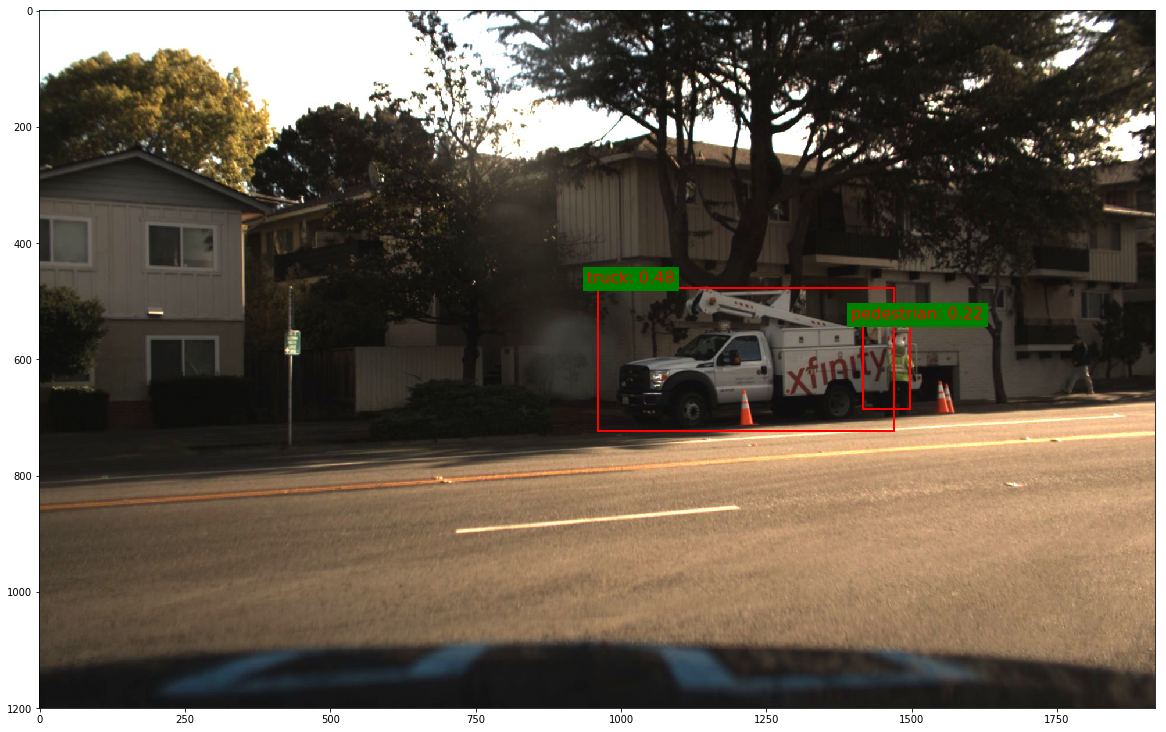

In [232]:
im = np.array(img, np.uint8)
figure = plt.figure(figsize=(20, 20))
ax = figure.add_subplot(1, 1, 1)
ax.imshow(im)

# Add the bouding boxes to the image
for i in range(len(scores)):
    (left, right, top, bottom) = (
        (boxes[i][0] - boxes[i][2]/2) * im.shape[1],
        (boxes[i][0] + boxes[i][2]/2) * im.shape[1],
        (boxes[i][1] - boxes[i][3]/2) * im.shape[0],
        (boxes[i][1] + boxes[i][3]/2) * im.shape[0])
    rect = patches.Rectangle((left, top), right - left, bottom - top, linewidth = 2, edgecolor = 'r', facecolor = 'none')
    ax.add_patch(rect)
    ax.text(left - 20, top - 10, labels[classes[i]] + ": " + format(scores[i], '.2f'), fontsize = 16, color = 'red', backgroundcolor='green')

plt.show()

## Pre-trained YOLO v2 model

In [234]:
tf.reset_default_graph()
session = tf.Session()
saver = tf.train.import_meta_graph("./driving_data/tiny-yolo-v2/tiny-yolo-udacity-8987.meta")
saver.restore(session, './driving_data/tiny-yolo-v2/tiny-yolo-udacity-8987')
graph = tf.get_default_graph()
tf.summary.FileWriter("./driving_data/tiny-yolo-v2/logs", graph).close()

INFO:tensorflow:Restoring parameters from ./driving_data/tiny-yolo-v2/tiny-yolo-udacity-8987


This model's input has dimension $[?, 416, 416, 3]$, and output has dimension $[?, 13, 13, 50]$. 

From the network profile `./driving_data/tiny-yolo-v2/tiny-yolo-udacity.cfg`, we also extract the follwing anchors:


In [237]:
anchors = tf.constant([[1.08, 1.19], [3.42, 4.41], [6.63, 11.38], [9.42, 5.11], [16.62, 10.52]])

In [235]:
output = graph.get_tensor_by_name("output:0")

After getting the network output from the last convolutional layer, we need to perform a transformation to the coordinates. This transformation can be referred to the [paper](https://arxiv.org/pdf/1612.08242.pdf), and to the repository scripts [data.py](https://github.com/udacity/self-driving-car/blob/master/vehicle-detection/darkflow/net/yolov2/data.py), [train.py](https://github.com/udacity/self-driving-car/blob/master/vehicle-detection/darkflow/net/yolov2/train.py), [test.py](https://github.com/udacity/self-driving-car/blob/master/vehicle-detection/darkflow/net/yolov2/test.py).


In [271]:
def postprocess(net_out, anchors, S = 13, B = 5, C = 5, filter_threshold = 0.2, iou_threshold = 0.4, max_boxes=10):
    SS = S * S
    net_out = tf.reshape(net_out, [-1, S, S, B, 10])
    coords = net_out[:, :, :, :, :4]
    confs = tf.sigmoid(net_out[:, :, :, :, 4:5])
    probs = tf.nn.softmax(net_out[:, :, :, :, 5:], dim = -1)
    
    # Change the coords to be relative to the whole image
    grid_rows = tf.tile(tf.reshape(tf.range(S, dtype=tf.float32), [S, 1]), [1, S])
    grid_columns = tf.tile(tf.reshape(tf.range(S, dtype=tf.float32), [1, S]), [S, 1])
    grid = tf.stack([grid_columns, grid_rows], axis = 2)
    grid = tf.tile(tf.reshape(grid, [S, S, 1, 2]), [1, 1, B, 1])
    coords_center = (tf.sigmoid(coords[:, :, :, :, :2]) + grid) / S
    coords_wh = tf.exp(coords[:, :, :, :, 2:]) * anchors / S
    coords = tf.concat([coords_center, coords_wh], axis = 4)
    
    # Filter out boxes with low classes scores
    scores, boxes, classes = yolo_filter_boxes(box_class_probs=probs, box_confidence=confs, boxes=coords, threshold=filter_threshold)
    
    # non max suppresion
    scores, boxes, classes = yolo_non_max_suppression(boxes=boxes, classes=classes, scores=scores, iou_threshold=iou_threshold, max_boxes=max_boxes)
    
    return scores, boxes, classes

In [316]:
img = Image.open("./driving_data/object-dataset/" + annotation["frame"][88294])
img_yolo = img.resize((416, 416))
img_yolo = np.array(img_yolo, np.uint8) / 255.
img_yolo = img_yolo[np.newaxis, :]
scores, boxes, classes = postprocess(output, anchors)
scores, boxes, classes = session.run([scores, boxes, classes], feed_dict={'input:0': img_yolo})

In [317]:
scores, classes

(array([ 0.86231494,  0.79163277,  0.58157998,  0.49936053], dtype=float32),
 array([0, 3, 0, 4]))

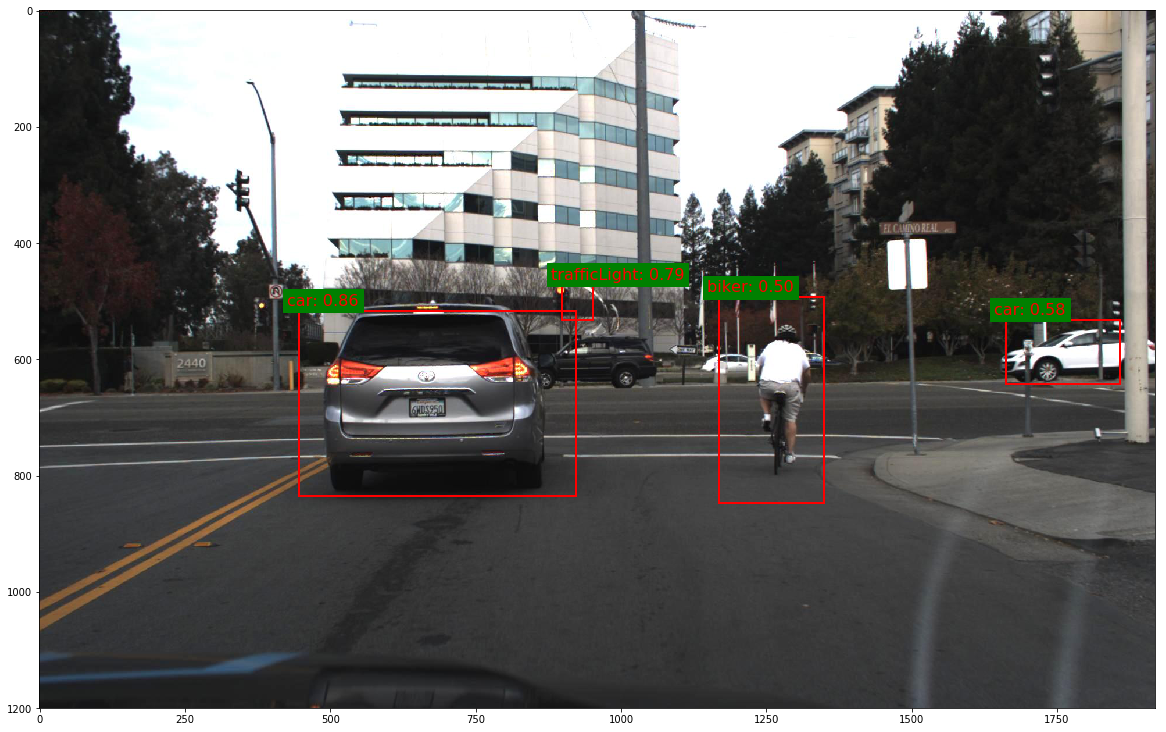

In [318]:
im = np.array(img, np.uint8)
figure = plt.figure(figsize=(20, 20))
ax = figure.add_subplot(1, 1, 1)
ax.imshow(im)

# Add the bouding boxes to the image
for i in range(len(scores)):
    (left, right, top, bottom) = (
        (boxes[i][0] - boxes[i][2]/2) * im.shape[1],
        (boxes[i][0] + boxes[i][2]/2) * im.shape[1],
        (boxes[i][1] - boxes[i][3]/2) * im.shape[0],
        (boxes[i][1] + boxes[i][3]/2) * im.shape[0])
    rect = patches.Rectangle((left, top), right - left, bottom - top, linewidth = 2, edgecolor = 'r', facecolor = 'none')
    ax.add_patch(rect)
    ax.text(left - 20, top - 10, labels[classes[i]] + ": " + format(scores[i], '.2f'), fontsize = 16, color = 'red', backgroundcolor='green')

plt.show()

In [ ]:
session.close()